# Download and Unzip

In [1]:
# Downloading data set
!wget https://dl.dropboxusercontent.com/s/d4d856dldpp6xv4/segmentation_data.zip
!unzip segmentation_data.zip

--2023-04-26 15:59:23--  https://dl.dropboxusercontent.com/s/d4d856dldpp6xv4/segmentation_data.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6030:15::a27d:500f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11763176 (11M) [application/zip]
Saving to: ‘segmentation_data.zip’

segmentation_data.z 100%[===================>]  11.22M  63.3MB/s    in 0.2s    

2023-04-26 15:59:24 (63.3 MB/s) - ‘segmentation_data.zip’ saved [11763176/11763176]

Archive:  segmentation_data.zip
  inflating: test_gt.npy             
  inflating: test_image.npy          
  inflating: train_gt.npy            
  inflating: train_image.npy         


#Import Neccecary Packages

In [3]:
# First we import the necessary packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

In [ ]:
# The next step is loading data

# Load Data

In [ ]:
#We will dfine a load_data method 

In [6]:
def load_data(path):
  return np.load(os.path.join(path, 'train_image.npy')), \
           np.load(os.path.join(path, 'train_gt.npy')), \
           np.load(os.path.join(path, 'test_image.npy')),\
           np.load(os.path.join(path, 'test_gt.npy'))
# np.load will load the given file to the memory.

In [7]:
# With the previously defined method we can load the data
train_img, train_mask, test_img, test_mask = load_data('./')
test_mask.shape

(200, 60, 80, 3)

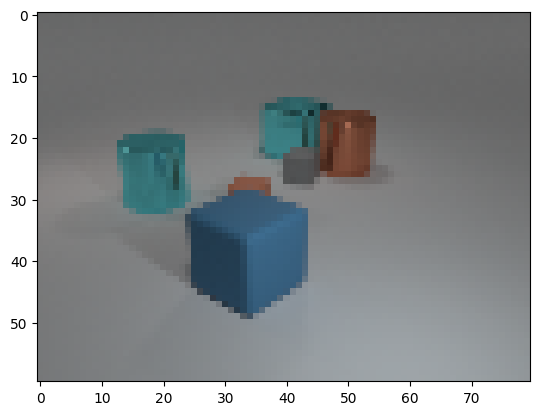

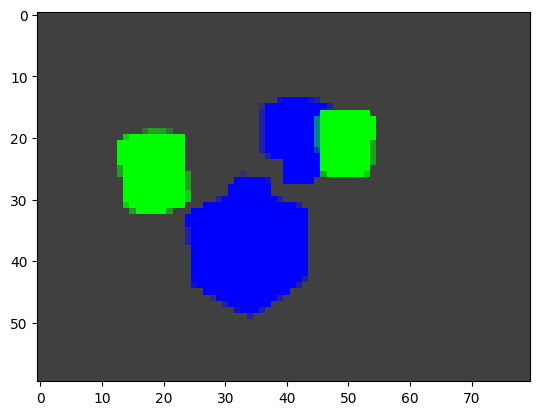

In [8]:
# Now lets Check what we have in the downloaded data
plt.imshow(train_img[0, :]/255)
plt.show()
plt.imshow(train_mask[0, :]/255)
plt.show()

In [58]:
print(train_mask.shape)

(1000, 60, 80, 3)


In [59]:
print(train_mask[0, 20:30,20:30,2])

[[ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 32. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 32. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 32. 64. 64. 64. 64. 64.]
 [ 0.  0.  0.  0. 16. 64. 64. 64. 64. 64.]]


In [ ]:
# Now lets define some methods for building of UNET

# Define Methods

In [12]:
# We are using DoubleConv In many places in the architechture. So first we will define this one.
import torchvision
# This will be the class double conv
class DoubleConv(nn.Module): # If we want to use a class as a building block of an architechture the we have to inherit nn.Module
    def __init__(self, in_channels, out_channels):
        super().__init__() # First we have to initialize the ancestor
        self.double_conv = nn.Sequential( # nOW WE WILL define the double_conv which will contain the 2 convolutions with batchnorm
            nn.Dropout(0.2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)


# First lets define a class for creating downsampling layers: 
class Down(nn.Module): 
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels): # This will wait for two inputs: the number of in_channels and ...
        super().__init__() 
        self.maxpool_conv = nn.Sequential( # After we will define maxpool_conv which consist of a..
            DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    def forward(self, x): # In the forward prop we will apply this on the input x.
        return self.maxpool_conv(x)

# After lets define a class for UP layers
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels): 
        super().__init__() # First we have to initialize the ancestor

        # After lets define the parts of up layer. In this we have
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            #the floor division // rounds the result down to the nearest whole number
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2): # In the forward prop we have two inputs: one is coming from down (x1) and one
                               # is coming from the skip connection (x2)
        x1 = self.up(x1) # We will apply the transpose conv o the x1

        # NOw we will calculate what is the difference in x and y direction btween the size of x1 and x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # It is important to calculate how mutch padding we needin the different 
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # wITH TORCH cat we can concatenate the two tensor
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
 
# Finally we will define a class for the outCon which
# will take us back to the out_channel num.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

In [13]:
def get_next_batch(img, mask, batch_length):
    assert len(img) == len(mask)

    used_in_batch = random.sample(range(len(img)), batch_length)
    imgs = img[used_in_batch, :]
    masks = mask[used_in_batch, :]
    imgs = np.swapaxes(imgs,1,3)
    masks = np.swapaxes(masks,1,3)
    imgs = torch.from_numpy(imgs)
    masks = torch.from_numpy(masks)
    return imgs, masks

# define unet:

In [15]:
import torchvision.transforms as transforms

In [40]:
class Net(nn.Module):
  def __init__(self, i_ch_n, o_ch_n,dropout,b_t):
    super(Net, self).__init__()
    self.do= dropout
    self.b_t=b_t
    # parameters:
    self.input_channel_num = i_ch_n
    self.output_channel_num = o_ch_n
    #self.bilinear = bilinear

    # downscaleing layers
    self.inc = DoubleConv(self.input_channel_num, 64)
    self.dropout1 = nn.Dropout2d(p=self.do) 
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 1 #if bilinear else 1
    self.down4 = Down(512, 1024 // factor)

    # upscaling layers
    self.up1 = Up(1024, 512 // factor)
    self.up2 = Up(512, 256 // factor)
    self.up3 = Up(256, 128 // factor)
    self.up4 = Up(128, 64)
    self.outconv = OutConv(64, self.output_channel_num)

  def forward(self, x):
      if self.b_t:
        blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        x = blur_transform(x)

      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.up3(x, x2)
      x = self.up4(x, x1)
      logits = self.outconv(x)
      return logits

In [18]:
net = Net(3, 3).cuda() # 3 csatornas bemenet es 3 csatornas kimenet

In [71]:
print(net)

Net(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
          (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
          (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

# Train Network

In [20]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import random

In [47]:
# train parameters
epochs=500
batch_size=16
lr=0.001
val_percent=0.1
save_cp=True
img_scale=0.5

In [26]:
print(criterion)

MSELoss()


itertools

In [48]:
imgs, true_masks = get_next_batch(train_img, train_mask, batch_size)
print(imgs.shape)
print(true_masks.shape)

torch.Size([16, 3, 80, 60])
torch.Size([16, 3, 80, 60])


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
losses = []

In [58]:
import itertools

dropout = [0.0, 0.2]
weight_d = [0.1, 0.01, 0.001]
GB = [True, False]



product = itertools.product(dropout, weight_d,GB)


for item in product:
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=item[1])
  

  if net.output_channel_num > 1:
    criterion = nn.MSELoss()
  else:
    criterion = nn.BCEWithLogitsLoss()

  print(item)
    #modell generation:
  net = Net(3, 3,item[0],item[2]).cuda()
    #------------------

  print("New Net is considered with values:")
  print(item)
  for epoch in range(epochs):


    epoch_loss = 0
    net.train()

      # create batches of imgs and masks
    imgs, true_masks = get_next_batch(train_img, train_mask, batch_size)
    assert imgs.shape[1] == net.input_channel_num, \
        f'Network has been defined with {net.input_channel_num} input channels, ' \
        f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
        'the images are loaded correctly.'
      
      #imgs = imgs/255
      #true_masks = true_masks/255
    imgs = imgs.to(device=device, dtype=torch.float32)
    mask_type = torch.float32 #if net.input_channel_num == 1 else torch.long
    true_masks = true_masks.to(device=device, dtype=mask_type)

      # run network on the current batch
    masks_pred = net(imgs)

    loss = criterion(masks_pred, true_masks)
    epoch_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()

    if epoch % 10 == 0:
      print("loss: " + str(epoch_loss))
      losses.append(epoch_loss)









(0.0, 0.1, True)
New Net is considered with values:
(0.0, 0.1, True)
loss: 5840.37060546875
loss: 5757.69970703125
loss: 5707.205078125
loss: 5970.4736328125
loss: 5940.5244140625
loss: 5655.2822265625
loss: 5924.10693359375
loss: 5819.091796875
loss: 5960.7041015625
loss: 5637.7822265625
loss: 5977.13720703125
loss: 5953.44970703125
loss: 5941.17333984375
loss: 5830.14111328125
loss: 5880.291015625
loss: 5700.78125
loss: 5828.41015625
loss: 5739.71728515625
loss: 5644.15380859375
loss: 5920.7353515625
loss: 5750.81689453125
loss: 6058.53466796875
loss: 6090.931640625
loss: 5622.7392578125
loss: 6026.73388671875
loss: 5691.04443359375
loss: 5998.51904296875
loss: 5835.4599609375
loss: 5841.8212890625
loss: 5966.26220703125
loss: 5882.39697265625
loss: 5732.94921875
loss: 6051.1376953125
loss: 5953.34033203125
loss: 5700.7880859375
loss: 5761.5078125
loss: 5742.9091796875
loss: 5577.7314453125
loss: 5762.71337890625
loss: 5950.8525390625
loss: 5793.28759765625
loss: 5952.85791015625
los

KeyboardInterrupt: ignored

First implementation:
loss: 3012.58056640625 the final loss.

Dropout added with 0.2 rate:
loss: 2945.4140625 improved

With a 0.2 dropout rate and a 0.1:
loss: 1264.6983642578125
improved,


with torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)):

losses increased loss: 3605.037353515625




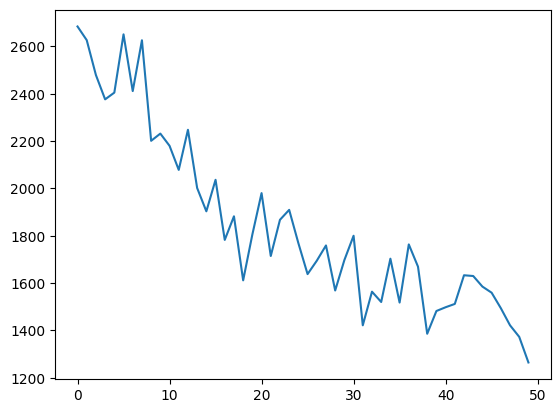

In [50]:
plt.plot(losses)

# Test

In [ ]:
# LETS TEST IT BY view some test images

In [51]:
imgs, true_masks = get_next_batch(test_img, test_mask, batch_size)

imgs = imgs.to(device=device, dtype=torch.float32)
mask_type = torch.float32 #if net.input_channel_num == 1 else torch.long
true_masks = true_masks.to(device=device, dtype=mask_type)

In [52]:
masks_pred = net(imgs)

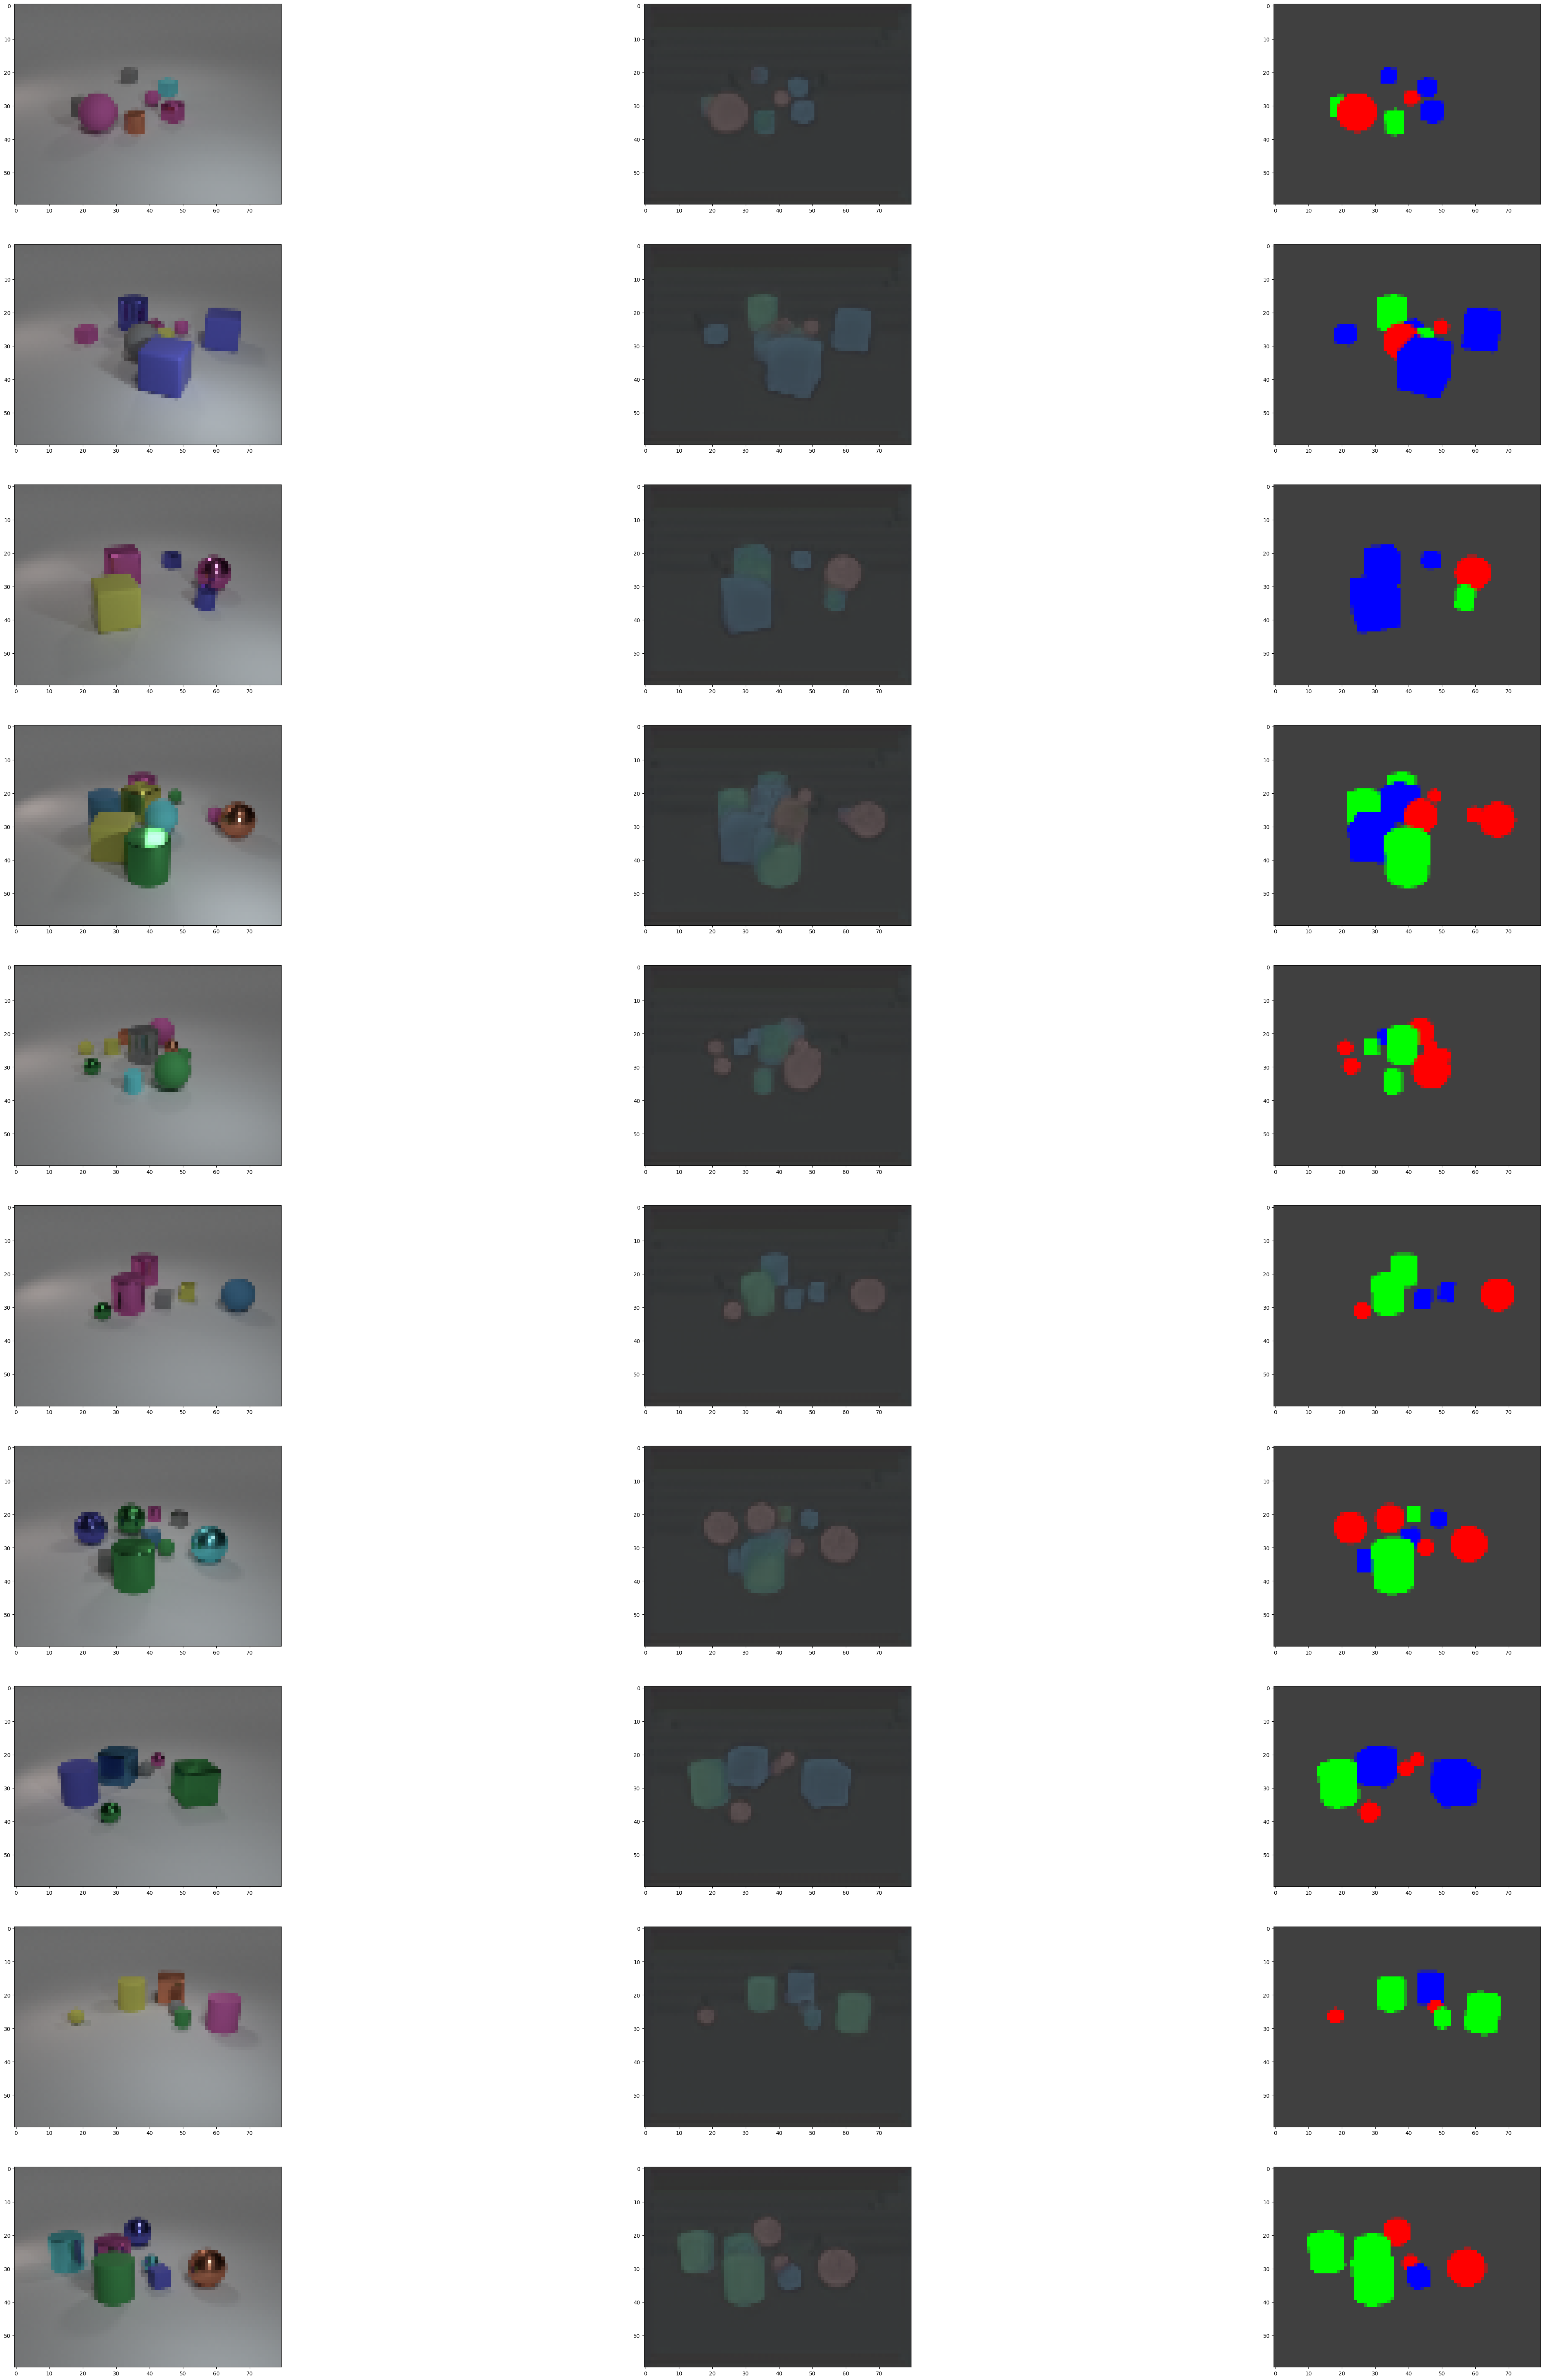

In [53]:
fig = plt.figure(figsize=(60, 80))
ax = fig.subplots(nrows=10, ncols=3)

for i in range(10):
  img = imgs[i].cpu().detach().numpy() 
  img = np.swapaxes(img,0,2)
  ax[i, 0].imshow(img/ 255)

  img = masks_pred[i].cpu().detach().numpy()
  img = np.swapaxes(img,0,2)
  ax[i, 1].imshow(img/ 255)

  img = true_masks[i].cpu().detach().numpy()
  img = np.swapaxes(img,0,2)
  ax[i, 2].imshow(img/ 255)